In [4]:
import os
from dotenv import load_dotenv
import requests
from openai import OpenAI
import time
import re
import hashlib
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import islice
from tqdm import tqdm
import time
import ast
from collections import defaultdict
import pdfplumber
import re
from difflib import get_close_matches
import json

load_dotenv()

True

In [ ]:
# READ
with open("all_pdfs.txt", 'r') as f:
    pdf_urls = ast.literal_eval(f.read())

# pdf_urls

In [ ]:
def safe_filename(title, max_len=150):
    title = re.sub(r'[<>:"/\\|?*]', '', title)

    title = re.sub(r'\s+', ' ', title).strip()

    if len(title) > max_len:
        hash_suffix = hashlib.md5(title.encode()).hexdigest()[:8]
        title = title[:max_len] + "_" + hash_suffix

    return title

In [ ]:
def download_pdf(url, output_path, retries=2, timeout=30):
    os.makedirs("pdfs", exist_ok=True)
    output_path = os.path.join("pdfs", output_path)

    for attempt in range(retries + 1):
        try:
            response = requests.get(url, stream=True, timeout=timeout)
            response.raise_for_status()

            with open(output_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            return

        except Exception as e:
            if attempt < retries:
                print(f"Retry {attempt + 1}/{retries} for {output_path} — {e}")
                time.sleep(1.5)  # small backoff
            else:
                print("Download failed for", output_path, ":", e)
                return


# pdf_url = pdf_urls[0]["source"]
# download_pdf(pdf_url, pdf_urls[0]["title"]+".pdf")


In [ ]:
tasks = []
saved = defaultdict(int)

for pdf_url in pdf_urls:
    if pdf_url.get("type") != "pdf":
        continue

    url = pdf_url["source"]
    base_title = safe_filename(pdf_url["title"])

    saved[base_title] += 1
    count = saved[base_title]

    if count > 1:
        safe_title = f"{base_title}_{count}"
    else:
        safe_title = base_title

    output_path = f"{safe_title}.pdf"
    tasks.append((url, output_path))

In [ ]:
print(len(tasks))

In [ ]:
def batch_iterable(iterable, batch_size):
    it = iter(iterable)
    while batch := list(islice(it, batch_size)):
        yield batch

BATCH_SIZE = 100       # number of PDFs per batch
MAX_WORKERS = 8        # threads per batch
BATCH_DELAY = 0.4      # seconds between batches

for batch in batch_iterable(tasks, BATCH_SIZE):
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [
            executor.submit(download_pdf, url, output_path)
            for url, output_path in batch
        ]

        for _ in tqdm(as_completed(futures), total=len(futures)):
            pass

    time.sleep(BATCH_DELAY)

In [ ]:
def pdf_to_txt(pdf_path):
    os.makedirs("txts", exist_ok=True)
    try:
        text = ""
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text+= page.extract_text() + '\n\n'
        txt_path = os.path.join("txts", pdf_path[5:-4]+".txt")
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(text)
    except Exception as e:
        print("Error with ", pdf_path, ": ", e)

for file in tqdm(os.listdir("pdfs")):
    pdf_path = os.path.join("pdfs", file)
    pdf_to_txt(pdf_path)

In [ ]:
print(len(os.listdir('txts')))

In [ ]:
reference_extraction_tool = {
    "type": "function",
    "name": "extract_references",
    "description": "Extract the current circular name and all explicitly referenced documents with page numbers",
    "parameters": {
        "type": "object",
        "properties": {
            "circular": {
                "type": "string",
                "description": (
                    "The exact official name or identifier of the current circular being processed, "
                    "as it appears in the document text"
                )
            },
            "references": {
                "type": ["array", "null"],
                "description": (
                    "A list of external documents explicitly referenced in the current document, "
                    "along with the page numbers on which each document is mentioned"
                ),
                "items": {
                    "type": "object",
                    "properties": {
                        "document": {
                            "type": "string",
                            "description": (
                                "The exact title or official identifier of a referenced document "
                                "(such as a SEBI circular, regulation, act, or guideline) "
                                "as it appears verbatim in the text"
                            )
                        },
                        "pages": {
                            "type": "array",
                            "description": (
                                "A list of 1-indexed page numbers in the current document "
                                "where this referenced document is explicitly mentioned. "
                                "If the page number cannot be determined reliably, return an empty list"
                            ),
                            "items": {"type": "integer"}
                        }
                    },
                    "required": ["document", "pages"]
                }
            }
        },
        "required": ["circular", "references"]
    }
}

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [ ]:
def get_references(file_path):
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    response = client.responses.create(
        model="gpt-4o-mini",
        input=[
            {
                "role": "system",
                "content": "You extract references of documents from a given document."
            },
            {
                "role": "user",
                "content": f"""
You MUST call the extract_references function.

Rules:
- Always call the function
- If no references exist, set references = null
- Do NOT output text
- Do NOT explain anything

Document:
{text}
"""
            }
        ],
        tools=[reference_extraction_tool],
        tool_choice={
            "type": "function",
            "name": "extract_references"
        }
    )

    for item in response.output:
        if item.type == "function_call" and item.name == "extract_references":
            return json.loads(item.arguments)

    print("RAW OUTPUT:", response.output)
    raise ValueError("No function output returned by model")

In [7]:
knowledge_graph = {}

os.makedirs("debug", exist_ok=True)

for file in tqdm(os.listdir("files")):
    if not file.endswith(".txt"):
        continue

    file_path = os.path.join("files", file)

    try:
        result = get_references(file_path)

        circular = result["circular"]
        references = result["references"]

        knowledge_graph.setdefault(circular, []).extend(references or [])

        with open("debug/knowledge_graph.txt", "w", encoding="utf-8") as f:
            f.write(json.dumps(knowledge_graph, indent=2))

        time.sleep(0.4)

    except Exception as e:
        print(f"Error processing {file}: {e}")

print()
print(json.dumps(knowledge_graph, indent=2))

100%|██████████| 783/783 [34:03<00:00,  2.61s/it]


{
  "CIR/HO/MIRSD/MIRSD2/CIR/P/2017/59": [
    {
      "document": "Securities and Exchange Board of India Act, 1992",
      "pages": [
        1
      ]
    }
  ],
  "SEBI/HO/FPI&C/P/CIR/2021/0569": [
    {
      "document": "SEBI Circular No. IMD/FPI&C/CIR/P/2019/124",
      "pages": [
        6
      ]
    }
  ],
  "SEBI/HO/MIRSD/POD-1/P/CIR/2024/81": [
    {
      "document": "SEBI/HO/MIRSD/POD-1/CIR/2023/193",
      "pages": [
        1
      ]
    },
    {
      "document": "SEBI Master Circular No. SEBI/HO/IMD/IMD-PoD-1/P/CIR/2023/74",
      "pages": [
        3
      ]
    },
    {
      "document": "SEBI Master Circular No. SEBI/HO/MRD/MRD-PoD-2/P/CIR/2023/166",
      "pages": [
        3
      ]
    }
  ],
  "Circular NO.1": [],
  "CIR/MIRSD/ 09 /2012": [
    {
      "document": "CIR/MIRSD/16/2011",
      "pages": [
        1
      ]
    },
    {
      "document": "MIRSD/SE/Cir-21/2011",
      "pages": [
        1
      ]
    },
    {
      "document": "MIRSD/Cir-26/2011",
 

In [8]:
with open("debug/knowledge_graph.json", "w", encoding="utf-8") as f:
    json.dump(knowledge_graph, f, indent=2, ensure_ascii=False)

In [5]:
with open("../debug\knowledge_graph.json", "r", encoding="utf-8") as f:
    knowledge_graph = json.load(f)

In [6]:
def normalize(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    # Replace common separators with space
    text = re.sub(r"[\/,_\-]", "", text)
    # Collapse multiple spaces
    text = re.sub(r"\s+", "", text)
    return text


In [7]:
documents = {normalize(d):d for d in knowledge_graph.keys()}
documents

{'cirhomirsdmirsd2cirp201759': 'CIR/HO/MIRSD/MIRSD2/CIR/P/2017/59',
 'sebihofpi&cpcir20210569': 'SEBI/HO/FPI&C/P/CIR/2021/0569',
 'sebihomirsdpod1pcir202481': 'SEBI/HO/MIRSD/POD-1/P/CIR/2024/81',
 'circularno.1': 'Circular NO.1',
 'cirmirsd092012': 'CIR/MIRSD/ 09 /2012',
 'mrddopsecir072009': 'MRD/DoP/SE/Cir-07/2009',
 'cirmrddrmnp412018february202018': 'CIR/MRD/DRMNP/41 /2018 February 20, 2018',
 'cirmrddrmnp332017': 'CIR/MRD/DRMNP/ 33 /2017',
 'sebihoimdfiiccirp2017068': 'SEBI/HO/IMD/FIIC/CIR/P/2017/068',
 'cirmrddrmnp652016': 'CIR/MRD/DRMNP/65/2016',
 'circularsebihomirsddopcirp201905january042019': 'CIRCULAR SEBI/HO/MIRSD/DOP/CIR/P/2019/05 January 04, 2019',
 'cirmrddp372010': 'CIR/MRD/DP/ 37 /2010',
 'sebihomirsdsecfatfpcir202574': 'SEBI/HO/MIRSD/SECFATF/P/CIR/2025/74',
 'cirmrddp202010': 'CIR/MRD/DP/ 20 /2010',
 'sebihomrddsacirp201792': 'SEBI/HO/MRD/DSA/CIR/P/2017/92',
 'circularcirmrddp212012august022012': 'CIRCULAR CIR/MRD/DP/ 21 /2012 August 02, 2012',
 'circularno.fittccust1

In [12]:
from difflib import get_close_matches, SequenceMatcher

def is_similar(doc_name, documents, threshold=0.3):
    matches = get_close_matches(
        doc_name,
        documents.keys(),
        n=1,
        cutoff=threshold
    )

    if not matches:
        return False, None, 0.0

    best_match = matches[0]
    score = SequenceMatcher(None, doc_name, best_match).ratio()

    return True, documents[best_match], score

In [13]:
is_similar(
    normalize("Securities and Exchange Board of India Act, 1992"),
    documents,
)

(True,
 'SECURITIES AND EXCHANGE BOARD OF INDIA NOTIFICATION',
 0.8235294117647058)

In [14]:
for circular in tqdm(knowledge_graph):
    cleaned_refs = []
    for ref in knowledge_graph[circular]:
        similar, _, score = is_similar(normalize(ref["document"]), documents)
        if similar:
            cleaned_refs.append(ref)
        else:
            print("Removing FP:", ref, score)

    knowledge_graph[circular] = cleaned_refs


 72%|███████▏  | 1898/2649 [07:14<01:44,  7.16it/s]

Removing FP: {'document': 'letter from Chairman, SEBI addressed to the Chambers of Commerce namely FICCI, ASSOCHAM, CII, INDIAN MERCHANT’S CHAMBER, BOMBAY CHAMBER OF COMMERCE AND INDUSTRY', 'pages': [1]} 0.0


 87%|████████▋ | 2313/2649 [08:10<00:54,  6.16it/s]

Removing FP: {'document': 'Applicability of Net Asset Value (NAV) for Income/Debt oriented Mutual Fund scheme(s)/plan(s) (other than liquid fund schemes', 'pages': [1]} 0.0


 88%|████████▊ | 2320/2649 [08:15<02:13,  2.47it/s]

Removing FP: {'document': 'Guidelines regarding initial offer period, format for half yearly disclosures of Portfolio, unclaimed redemption amount, Annual reports of the AMCs for the unitholders, expenses chargeable to the schemes and prior approval for investment in unrated debt instruments', 'pages': [1]} 0.0


 88%|████████▊ | 2343/2649 [08:21<00:50,  6.11it/s]

Removing FP: {'document': 'Operative Guidelines for the two way fungibility under the "issue of Foreign Currency Convertible Bonds and Ordinary Shares (Through Depository Receipt Mechanism) Scheme 1993"', 'pages': [1]} 0.0


 89%|████████▊ | 2345/2649 [08:22<01:00,  5.00it/s]

Removing FP: {'document': 'Operative Guidelines for the two-way fungibility under the "issue of Foreign Currency Convertible Bonds and Ordinary Shares (Through Depository Receipt Mechanism) Scheme 1993"', 'pages': [1]} 0.0


100%|██████████| 2649/2649 [09:07<00:00,  4.84it/s]


In [ ]:
with open("debug/knowledge_graph_cleaned.json", "w", encoding="utf-8") as f:
    json.dump(knowledge_graph, f, indent=2, ensure_ascii=False)

In [16]:
with open("debug/knowledge_graph_cleaned.json", "r", encoding="utf-8") as f:
    knowledge_graph = json.load(f)

In [17]:
for key, references in tqdm(knowledge_graph.items()):
    for ref in references:
        doc_name = ref.get("document")
        if not doc_name:
            continue

        similar, doc, score = is_similar(doc_name, documents)
        if not similar:
            continue
        ref["document"] = doc


100%|██████████| 2649/2649 [05:06<00:00,  8.65it/s]


In [18]:
with open("debug/knowledge_graph_reference.json", "w", encoding="utf-8") as f:
    json.dump(knowledge_graph, f, indent=2, ensure_ascii=False)

d:\Projects\Hyde\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\Hyde\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\Hyde\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\Hyde\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\Hyde\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects

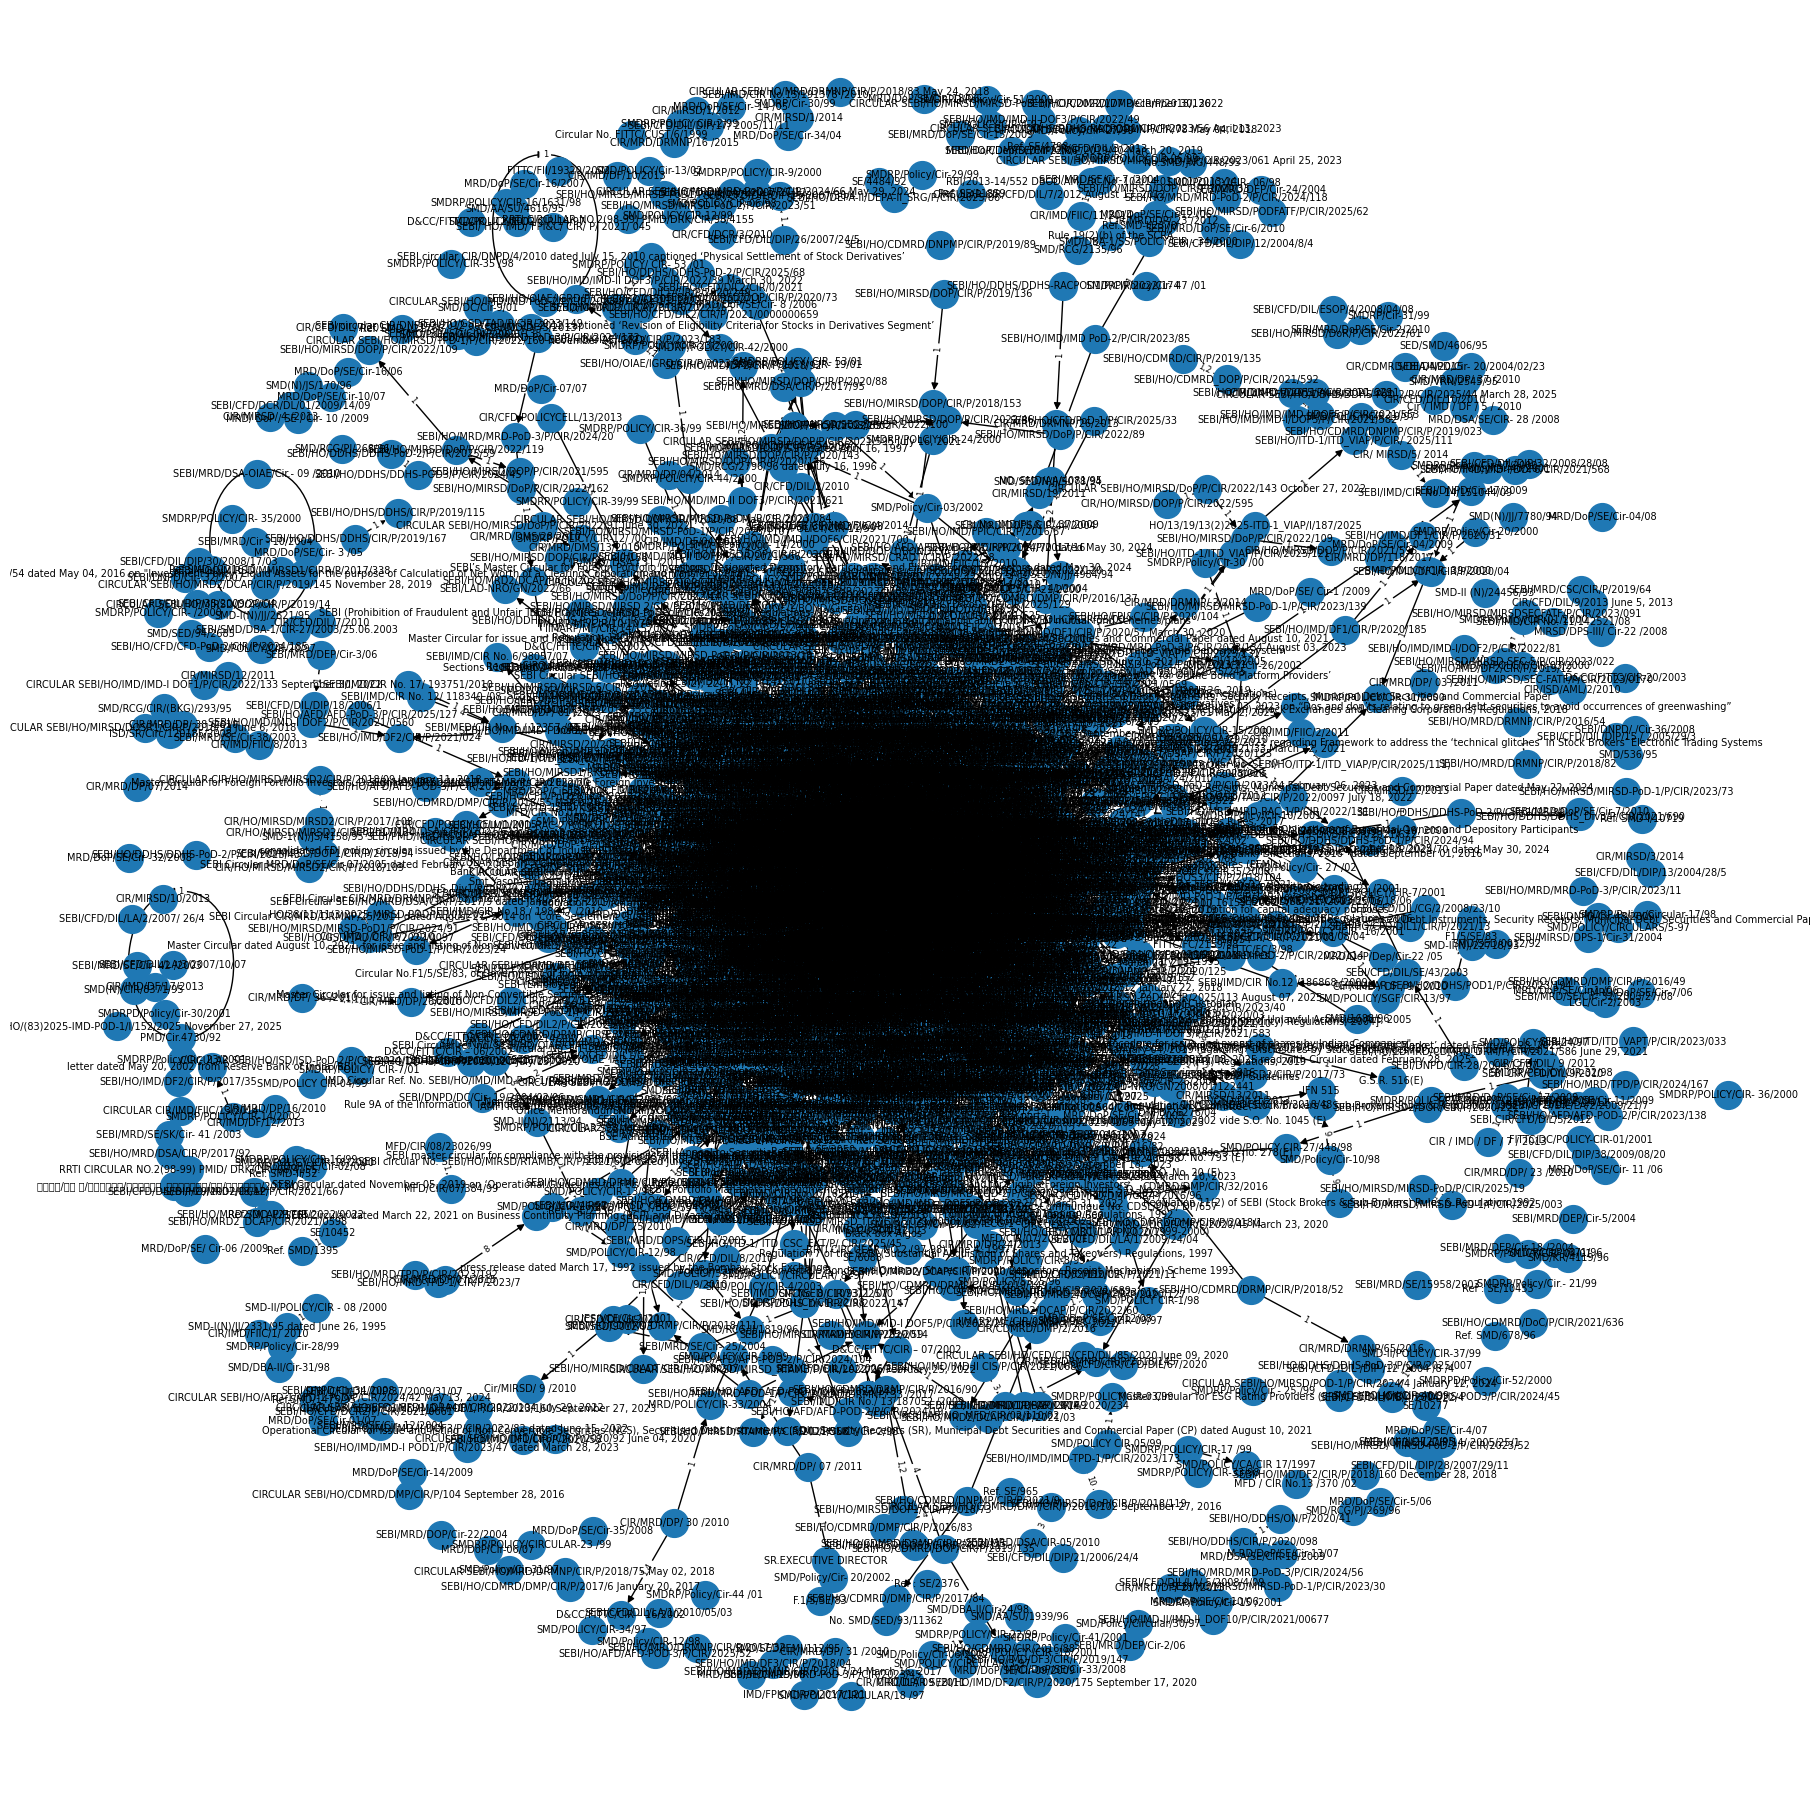

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(knowledge_graph):
    G = nx.DiGraph()

    for circular, refs in knowledge_graph.items():
        if not circular:
            continue

        G.add_node(circular, type="circular")

        for ref in refs:
            doc = ref.get("document")
            pages = ref.get("pages", [])

            if not doc:
                continue

            G.add_node(doc, type="reference")
            G.add_edge(circular, doc, pages=",".join(map(str, pages)))

    return G


G = build_graph(knowledge_graph)

plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw(
    G,
    pos,
    node_size=400,
    font_size=7,
    with_labels=True,
    arrows=True
)

edge_labels = nx.get_edge_attributes(G, "pages")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()


In [ ]:
from tqdm import tqdm
import os

FILES_DIR = "../files"

file_contents = {}
for file in os.listdir(FILES_DIR):
    if not file.endswith(".txt"):
        continue
    with open(os.path.join(FILES_DIR, file), "r", encoding="utf-8", errors="ignore") as f:
        file_contents[file] = f.read()

name_map = {}

for doc_key, name in tqdm(documents.items()):
    for file, content in file_contents.items():
        if name in content:
            name_map[name] = file[:-4]  # strip ".txt"
            break


100%|██████████| 2645/2645 [00:08<00:00, 296.85it/s]


In [13]:
with open("../debug/name_map.json", "w", encoding="utf-8") as f:
    json.dump(name_map, f, indent=1, ensure_ascii=False)